In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
#importing packages
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Lambda, Bidirectional, GRU, Conv1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
#setting figure size
rcParams['figure.figsize'] = 20,10

#for normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('/content/drive/My Drive/DATA/TSLA_2015_2020_5_minutes_interval.csv')

df['Date'] = df[['Date', 'Time']].apply(lambda x: '-'.join(x), axis=1)
#print the head
df

,Date,Time,Open,High,Low,Close,Up,Down
0,7/21/2015-9:35,9:35,270.19,273.50,269.00,272.32,173622,247452
1,7/21/2015-9:40,9:40,272.37,273.00,270.91,271.89,72013,102721
2,7/21/2015-9:45,9:45,271.62,273.40,271.52,272.99,76738,57058
3,7/21/2015-9:50,9:50,273.08,273.12,270.55,271.00,75595,90610
4,7/21/2015-9:55,9:55,271.13,271.18,268.33,268.53,99358,134652
...,...,...,...,...,...,...,...,...
98128,7/21/2020-15:40,15:40,1572.86,1573.93,1558.58,1564.33,60201,65424
98129,7/21/2020-15:45,15:45,1564.45,1570.86,1562.05,1570.59,37591,35607
98130,7/21/2020-15:50,15:50,1570.59,1582.42,1568.79,1580.54,53218,45424
98131,7/21/2020-15:55,15:55,1579.43,1579.43,1564.00,1571.44,52035,60239


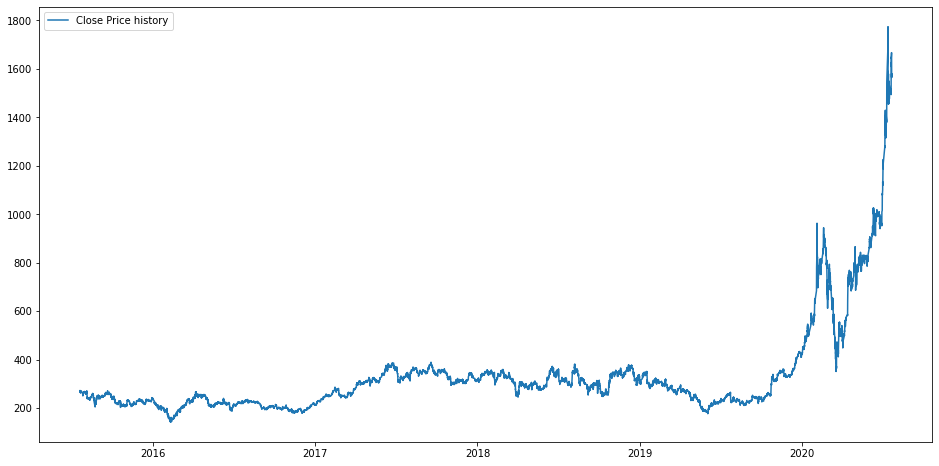

In [3]:
#setting index as date
#df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df['Date'] = pd.to_datetime(df.Date)
df.index = df['Date']
#df = df[df['Date'] < '2020-01-01']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')
plt.legend()

In [4]:
#creating dataframe
T = 3000 #training period
T_pred = 3000 #prediction period

data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[:-T_pred,:]
valid = dataset[-T_pred:,:]

len(train), len(valid)

(95133, 3000)

In [5]:
#converting dataset into x_train and y_train
# T = 30 #training period
# T_pred = T
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(T,len(train)-T_pred):
    x_train.append(scaled_data[i-T:i,0])
    y_train.append(scaled_data[i:i+T_pred,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#y_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1],1))
print(x_train.shape, y_train.shape)


(89133, 3000, 1) (89133, 3000)


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(Conv1D(filters=90, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape = [T,1]))
model.add(LSTM(units=90, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(units=90, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=150, activation='tanh'))
model.add(Dense(T_pred))
#model.add(Lambda(lambda x: x*500))

#model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch/ 20))
checkpoint = ModelCheckpoint(weight_save_path+model_name+'.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True, )
model.compile(loss=Huber(), optimizer=Adam(lr=0.001), metrics = ['mae'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 90, 90)            540       
_________________________________________________________________
lstm_41 (LSTM)               (None, 90, 90)            65160     
_________________________________________________________________
dropout_28 (Dropout)         (None, 90, 90)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 90, 90)            65160     
_________________________________________________________________
dropout_29 (Dropout)         (None, 90, 90)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 150)               144600    
_________________________________________________________________
dense_13 (Dense)             (None, 60)              

In [6]:
# create and fit the LSTM network
model_name = '1_CONV_5_LSTM_1_DENSE_SPY_JULY15_JAN20'
weight_save_path = '/content/drive/My Drive/LSTM/Results'

model = Sequential()
model.add(Conv1D(filters=300, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape = [T,1]))
# model.add(LSTM(units=300, return_sequences=True, activation='tanh'))
# model.add(Dropout(0.1))
# #model.add(BatchNormalization())
model.add(LSTM(units=1500, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
# model.add(LSTM(units=1500, activation='tanh', return_sequences= True))
# model.add(Dropout(0.2))
#model.add(BatchNormalization())
# model.add(LSTM(units=1500, activation='tanh', return_sequences= True))
# model.add(Dropout(0.5))
# #model.add(BatchNormalization())
model.add(LSTM(units=1500, activation='tanh'))
# model.add(Dense(1000))
# model.add(Dropout(0.2))
# model.add(Dense(10))
model.add(Dense(T_pred))
#model.add(Lambda(lambda x: x*500))


model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3000, 300)         1800      
_________________________________________________________________
lstm (LSTM)                  (None, 3000, 1500)        10806000  
_________________________________________________________________
dropout (Dropout)            (None, 3000, 1500)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1500)              18006000  
_________________________________________________________________
dense (Dense)                (None, 3000)              4503000   
Total params: 33,316,800
Trainable params: 33,316,800
Non-trainable params: 0
_________________________________________________________________


In [7]:
#callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch/ 20))
checkpoint = ModelCheckpoint(weight_save_path+model_name+'.h5', monitor='loss', save_best_only=True, save_weights_only=True, )


In [ ]:
import time
start = time.time()
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[lr_schedule])
end = time.time()
print('Run time: {}'.format((end-start)/60))

(1e-08, 0.01, 0.0, 1.0)

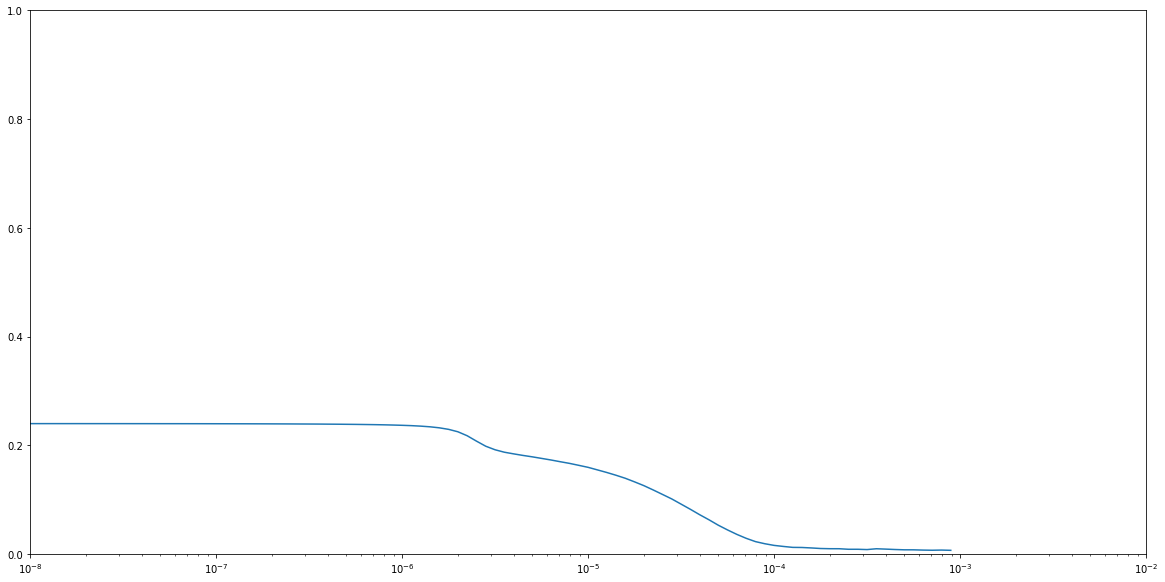

In [ ]:
#plotting loss per epoch against learning rate
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-2, 0, 1])
#use this to choose the optimum lr and run the NN for 500 epochs

In [1]:
class stop_training(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('loss')<0.0009):
      print("Stopping training")
      self.model.stop_training = True

stop_training = stop_training()
model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=['mae'])
import time
start = time.time()
history = model.fit(x_train, y_train, epochs=400, batch_size=16, callbacks=[checkpoint, stop_training])
end = time.time()
print('Run time: {}'.format((end-start)/60))

NameError: ignored

In [ ]:
model.load_weights(weight_save_path+model_name+'.h5')


In [ ]:
# #predicting 246 values, using past 60 from the train data
# inputs = new_data[len(new_data) - len(valid) - T:].values
# inputs = inputs.reshape(-1,1)
# inputs  = scaler.transform(inputs)

# X_test = []
# for i in range(T,inputs.shape[0]):
#     X_test.append(inputs[i-T:i,0])
# X_test = np.array(X_test)

# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# closing_price = model.predict(X_test)
# closing_price = scaler.inverse_transform(closing_price)

In [26]:
inputs = new_data[len(new_data) - len(valid) - T:len(new_data) - len(valid)].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = np.reshape(inputs, (1,-1,1))
X_test.shape
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price.shape

(1, 300)

In [ ]:
print(closing_price.shape)
print(X_test.shape)
print(valid.shape)

(1, 60)
(1, 30, 1)
(60, 1)


In [27]:
#rms error
rms=np.sqrt(np.mean(np.power((valid.reshape(1,-1) - closing_price),2)))
rms
#np.mean(np.abs(valid - closing_price))

37.02478900486572

In [28]:
np.std(valid)

53.77175373061171

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


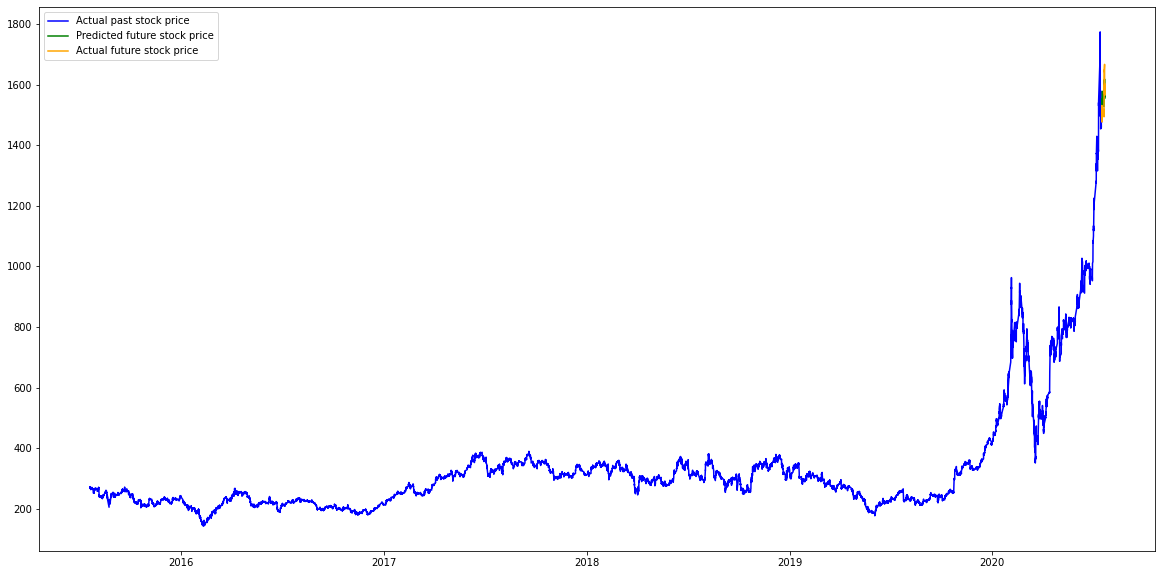

In [29]:
#for plotting
train = new_data[:-T_pred]
#train_pred = new_data[T:450]
valid = new_data[-T_pred:]
#train_pred['Predictions'] = closing_price_train
valid['Predictions'] = closing_price.reshape(-1,1)
plt.plot(train['Close'], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()

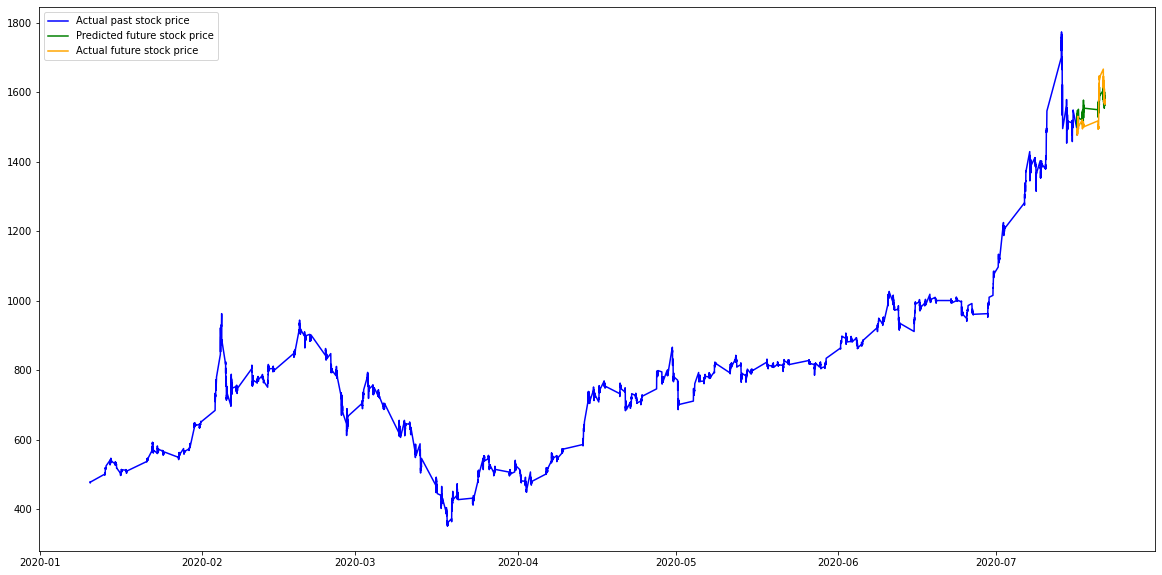

In [36]:
#zoomed plotting
plt.plot(train['Close'][-10000:], color='blue', label='Actual past stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()

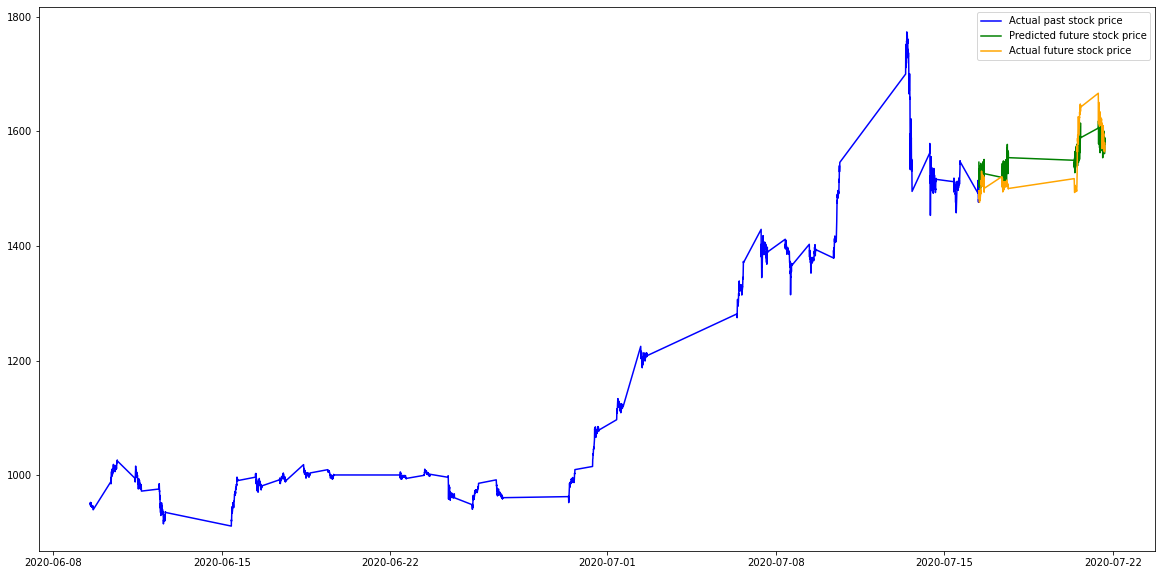

In [37]:
plt.plot(train['Close'][-2000:], color='blue', label='Actual past stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()

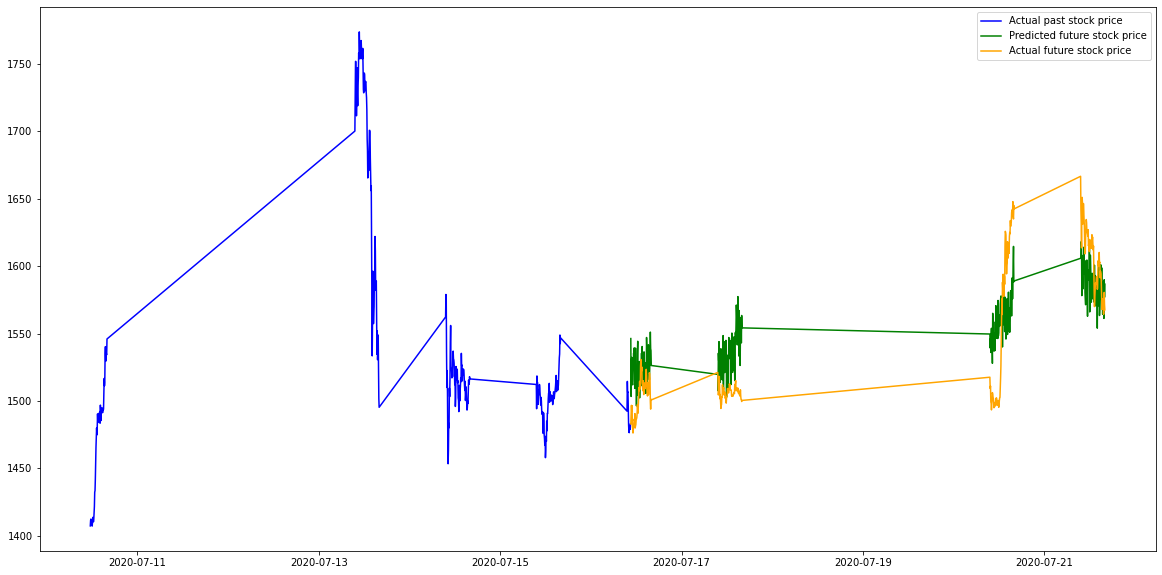

In [38]:
plt.plot(train['Close'][-300:], color='blue', label='Actual past stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()

In [32]:
valid

,Close,Predictions
Date,,
2020-07-16 10:35:00,1483,1546.316406
2020-07-16 10:40:00,1488.97,1503.404297
2020-07-16 10:45:00,1496.8,1530.000977
2020-07-16 10:50:00,1492.47,1532.373291
2020-07-16 10:55:00,1496.55,1528.835815
...,...,...
2020-07-21 15:40:00,1564.33,1588.400513
2020-07-21 15:45:00,1570.59,1561.244629
2020-07-21 15:50:00,1580.54,1589.918213


In [ ]:
inputs = new_data[len(new_data) - len(valid) - T:len(new_data) - len(valid)].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = np.reshape(inputs, (1,-1,1))
X_test.shape
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price.shape

In [ ]:
#Predictions on test set
closing_price = np.zeros((len(valid)))
X_test = []
for pred in range(len(closing_price)):
  #Single valued output
  if pred<T:
    X_test = new_data[len(train) - T + pred:len(train)].values
    X_test = X_test.reshape(-1,1)
    X_test = scaler.transform(X_test)
    if pred>0:
      X_test = np.concatenate((X_test, closing_price[:pred]), axis = None)  
  if pred>=T:
    X_test = closing_price[pred - T:pred]
  X_test = np.array(X_test)
  X_test = X_test.reshape(-1,1)
  #X_test  = scaler.transform(X_test)

  X_test = np.reshape(X_test, (X_test.shape[1],X_test.shape[0],1))
  closing_price[pred] = model.predict(X_test)
  #closing_price[pred] = scaler.inverse_transform(closing_price[pred]) 

closing_price = closing_price.reshape(-1,1)
closing_price = scaler.inverse_transform(closing_price)
closing_price.shape #single valued output prediction

In [ ]:
print(closing_price.shape)
print(X_test.shape)
print(x_train.shape)
print(y_train.shape)

(292, 1)
(1, 90, 1)
(710, 90, 1)
(710,)


In [ ]:
closing_price


In [ ]:
#rms error
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms
#np.mean(np.abs(valid - closing_price))

Close          163.078557
Predictions    158.291392
dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


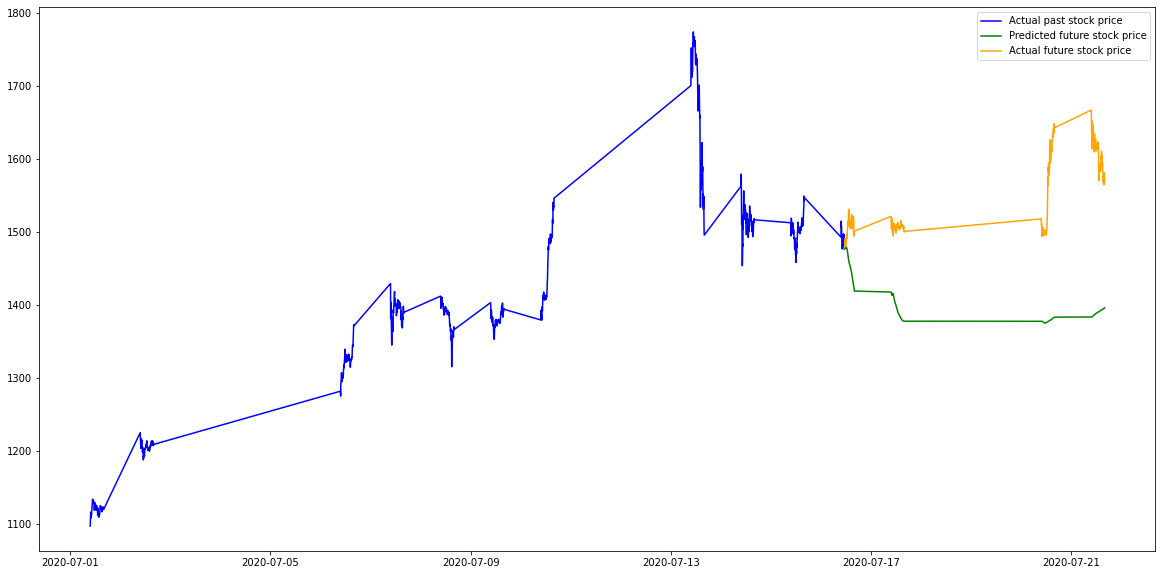

In [ ]:
#for plotting
train = new_data[:800]
#train_pred = new_data[T:450]
valid = new_data[800:]
#train_pred['Predictions'] = closing_price_train
valid['Predictions'] = closing_price
plt.plot(train['Close'], color='blue', label='Actual past stock price')
#plt.plot(train_pred['Predictions'], color='red', label='Predicted past stock price')
#plt.plot(valid['Predictions'], label='Predicted stock price')
plt.plot(valid['Predictions'], color = 'green', label='Predicted future stock price')
plt.plot(valid['Close'], color = 'orange', label='Actual future stock price')
plt.legend()



In [ ]:
valid

,Close,Predictions
Date,,
2019-11-01,1273.74,1244.864561
2019-11-04,1291.37,1235.571965
2019-11-05,1292.03,1225.102388
2019-11-06,1291.8,1212.246379
2019-11-07,1308.86,1201.619072
...,...,...
2020-07-14,1520.58,1195.485181
2020-07-15,1513.64,1195.874253
2020-07-16,1518,1196.312305


In [ ]:
valid.to_csv('/content/drive/My Drive/Covid 19 part(2)/Results_1/TESLA_Predicted_vs_Actual_Stock_Prices_JULY.csv')

In [ ]:
#Prediction for 22nd July, 2017
inputs = new_data[len(new_data) - T:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = inputs
X_test = X_test.reshape(1,T,1)

closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
print('Price on 22nd July : {}'.format(closing_price[0][0]))

Price on 22nd July : 1605.862060546875


In [ ]:
#learning rate decay(picking optimum learning rate)
lr_schedule = tf.keras.callbacks.LearningRateScheduler( lambda epoch: 1e-8 * 10**(epoch/ 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

In [ ]:
#plotting loss per epoch against learning rate
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])
#use this to choose the optimum lr and run the NN for 500 epochs

In [ ]:
#Conv1D
tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape = [None,1])

In [ ]:
#Converting the data in a df to float
df = df.astype('float64')

In [ ]:
#concatenating two colums
data['date_time'] = data['date'].str.cat(data['time'], sep=' ')

In [ ]:
#getting daily data from minute/hour wise data
df = df.resample('D').mean() # if we want mean of time data
df = df.resample('D').sum() # if we want sum of time data

In [ ]:
#evaluate model for multi-step LSTM
def evaluate_model(y_true, y_predicted):
  scores = []

  #calculating score for each day
  for i in range(y_true.shape[1]):
    mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
    rmse = np.sqrt(mse)
    scores.append(rmse)

  #calculating score for whole prediction
  total_score = 0
  for row in range(y_true.shape[0]):
    for col in range(y_predicted.shape[1]):
      total_score = total_score + (y_true[row,col] - y_predicted[row,col])**2
  total_score = np.sqrt(total_score/(y_true.shape[0]*y_predicted.shape[1]))

  return total_ score, scores

evaluate_model(y_true, y_pred)
np.std(y_true[0])



In [ ]:
data = pd.read_csv('/content/drive/My Drive/Covid 19 part(2)/LSTM/AAPL_JAN18_JULY20.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-19,178.610001,179.580002,177.410004,178.460007,172.341141,32425100
1,2018-01-22,177.300003,177.779999,176.600006,177.000000,170.931198,27108600
2,2018-01-23,177.300003,179.440002,176.820007,177.039993,170.969803,32689100
3,2018-01-24,177.250000,177.300003,173.199997,174.220001,168.246521,51105100
4,2018-01-25,174.509995,174.949997,170.529999,171.110001,165.243134,41529000
...,...,...,...,...,...,...,...
622,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
623,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
624,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
625,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
data_training = data[data['Date'] < '2019-12-31'].copy()
data_training

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-19,178.610001,179.580002,177.410004,178.460007,172.341141,32425100
1,2018-01-22,177.300003,177.779999,176.600006,177.000000,170.931198,27108600
2,2018-01-23,177.300003,179.440002,176.820007,177.039993,170.969803,32689100
3,2018-01-24,177.250000,177.300003,173.199997,174.220001,168.246521,51105100
4,2018-01-25,174.509995,174.949997,170.529999,171.110001,165.243134,41529000
...,...,...,...,...,...,...,...
485,2019-12-23,280.529999,284.250000,280.369995,284.000000,282.562683,24643000
486,2019-12-24,284.690002,284.890015,282.920013,284.269989,282.831299,12119700
487,2019-12-26,284.820007,289.980011,284.700012,289.910004,288.442780,23280300
488,2019-12-27,291.119995,293.970001,288.119995,289.799988,288.333313,36566500


In [ ]:
data_testing = data[data['Date'] >= '2019-12-31'].copy()
data_testing

,Date,Open,High,Low,Close,Adj Close,Volume
490,2019-12-31,289.929993,293.679993,289.519989,293.649994,292.163818,25201400
491,2020-01-02,296.239990,300.600006,295.190002,300.350006,298.829956,33870100
492,2020-01-03,297.149994,300.579987,296.500000,297.429993,295.924713,36580700
493,2020-01-06,293.790009,299.959991,292.750000,299.799988,298.282715,29596800
494,2020-01-07,299.839996,300.899994,297.480011,298.390015,296.879883,27218000
...,...,...,...,...,...,...,...
622,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
623,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
624,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
625,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
training_data = data_training.drop(['Date', 'Adj Close'], axis=1)
training_data

,Open,High,Low,Close,Volume
0,178.610001,179.580002,177.410004,178.460007,32425100
1,177.300003,177.779999,176.600006,177.000000,27108600
2,177.300003,179.440002,176.820007,177.039993,32689100
3,177.250000,177.300003,173.199997,174.220001,51105100
4,174.509995,174.949997,170.529999,171.110001,41529000
...,...,...,...,...,...
485,280.529999,284.250000,280.369995,284.000000,24643000
486,284.690002,284.890015,282.920013,284.269989,12119700
487,284.820007,289.980011,284.700012,289.910004,23280300
488,291.119995,293.970001,288.119995,289.799988,36566500


In [ ]:
scalar = MinMaxScaler()
training_data = scalar.fit_transform(training_data)
training_data.shape

(490, 5)

In [ ]:
x_train = []
y_train = []

T = 60
for i in range(T, training_data.shape[0]):
  x_train.append(training_data[i-T:i])
  y_train.append(training_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(430, 60, 5)
(430,)


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1],5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 50)            11200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 91,901
Trainable params: 91,901
Non-trainable params: 0
__________________________________________________

In [ ]:
import time
start = time.time()
model.fit(x_train, y_train, epochs=50, batch_size=8)
end = time.time()
print('Run time: {}'.format((end-start)/60))

Epoch 1/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0159
Epoch 2/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0041
Epoch 3/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0029
Epoch 4/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0030
Epoch 5/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0028
Epoch 6/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0028
Epoch 7/50
54/54 [==============================] - 2s 41ms/step - loss: 0.0024
Epoch 8/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0024
Epoch 9/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0038
Epoch 10/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0022
Epoch 11/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0019
Epoch 12/50
54/54 [==============================] - 2s 40ms/step - loss: 0.0020
Epoch 13/50
54/54 [==================

In [ ]:
past_T_days = data_training.tail(T)

df = past_T_days.append(data_testing, ignore_index = True)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-04,225.639999,227.490005,223.889999,227.009995,225.185043,34619700
1,2019-10-07,226.270004,229.929993,225.839996,227.059998,225.234634,30576500
2,2019-10-08,225.820007,228.059998,224.330002,224.399994,222.596024,27955000
3,2019-10-09,227.029999,227.789993,225.639999,227.029999,225.204895,18692600
4,2019-10-10,227.929993,230.440002,227.300003,230.089996,228.240280,28253400
...,...,...,...,...,...,...,...
192,2020-07-10,381.339996,383.920013,378.820007,383.679993,383.679993,22564300
193,2020-07-13,389.059998,399.820007,381.029999,381.910004,381.910004,47912300
194,2020-07-14,379.359985,389.019989,375.510010,388.230011,388.230011,42747300
195,2020-07-15,395.959991,396.989990,385.959991,390.899994,390.899994,38299500


In [ ]:
df = df.drop(['Date', 'Adj Close'], axis=1)
df

,Open,High,Low,Close,Volume
0,225.639999,227.490005,223.889999,227.009995,34619700
1,226.270004,229.929993,225.839996,227.059998,30576500
2,225.820007,228.059998,224.330002,224.399994,27955000
3,227.029999,227.789993,225.639999,227.029999,18692600
4,227.929993,230.440002,227.300003,230.089996,28253400
...,...,...,...,...,...
192,381.339996,383.920013,378.820007,383.679993,22564300
193,389.059998,399.820007,381.029999,381.910004,47912300
194,379.359985,389.019989,375.510010,388.230011,42747300
195,395.959991,396.989990,385.959991,390.899994,38299500


In [ ]:
inputs = scalar.transform(df)
inputs.shape

(197, 5)